<a href="https://colab.research.google.com/github/vijayrajendran123/NUS-SDS-Datathon-Champion/blob/main/Datathon_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

df1 = pd.read_csv('/content/drive/MyDrive/catA_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get information about our dataframe
print(df1.info())

# find the number of rows and columns in our dataset
print(df1.shape)

# find the names of columns in our dataset
print(df1.columns)

# check for the number of missing values in the dataframe
df1.isna().sum()

# show count, mean, std, and quintile information for each numerical column
df1.describe()

# a look at the first 10 rows of our data to get a gist of it
df2.head(10)

In [ ]:
# removes rows without values in any of these columns
df1 = df1.dropna(subset=['Year Found','Parent Company', 'Parent Country',
       'Employees (Domestic Ultimate Total)',
       'Is Domestic Ultimate'])

# Remove rows where the Company Status is 'Inactive'
df1 = df1[df1['Company Status (Active/Inactive)'] == 'Active']

# to ensure important info isnt being lost
df2['Import/Export Status_Missing'] = df2['Import/Export Status'].isna()

In [ ]:
df2 = pd.get_dummies(df1, columns=['Entity Type'], prefix='Entity_Type')
df2 = pd.get_dummies(df1, columns=['Import/Export Status'], prefix='Import_Export_Status')
df2 = df1.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df1.columns], errors='ignore') # are all Active

# Check the number of null values
df2.isna().sum()

In [ ]:
# Find the frequency of each industry
sic_code_frequency = df2['SIC Code'].value_counts()

# Set a threshold for low-frequency SIC Codes
threshold = 10

# Identify SIC Codes with frequency below the threshold
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

# Replace these low-frequency SIC Codes with a common label "Others"
df2['SIC Code'] = df2['SIC Code'].replace(low_frequency_sic_codes, 'Others')

sic_code_frequency1 = df2['SIC Code'].value_counts()

# Display the updated DataFrame
print(sic_code_frequency1)

# convert to str cus we dont want it to be trained as a numeric value
# Convert the entire column to a common data type (string in this case)
df2['SIC Code'] = df2['SIC Code'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Use label encoding for 'SIC Code'
label_encoder = LabelEncoder()
df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])

df3["SIC Code"].unique()

In [ ]:
# use of a correlation matrix to observe how variables in our dataset may be affected by others
numerical_df = df2.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
correlation_matrix = numerical_df.corr()

# Assuming correlation_matrix is your correlation matrix
correlation_df = pd.DataFrame(correlation_matrix)

# Print or use the correlation DataFrame as needed
correlation_df

In [ ]:
columns_to_drop = ["error", "Fiscal Year End", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                   "Square Footage", "Company Description", "PostCode", "8-Digit SIC Description", "AccountID", "Parent Company", "Parent Country",
                   "City", "Country", "Address", "Address1", "Industry", "Region", "Global Ultimate Country", "Company",
                   "LATITUDE", "LONGITUDE", "SIC Code", "Employees (Single Site)", "Employees (Global Ultimate Total)", "Is Global Ultimate"]

# Drop columns if they exist in the DataFrame
df3 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], errors='ignore')

print(df3.columns)

Index(['8-Digit SIC Code', 'Year Found', 'Employees (Domestic Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Is Domestic Ultimate'],
      dtype='object')


In [ ]:
# Convert 'Is Domestic Ultimate' to True/False
df3['Is Domestic Ultimate'] = df3['Is Domestic Ultimate'] == 1

df3.columns

Index(['8-Digit SIC Code', 'Year Found', 'Employees (Domestic Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Is Domestic Ultimate'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [ ]:
# Separate features and target variable
X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

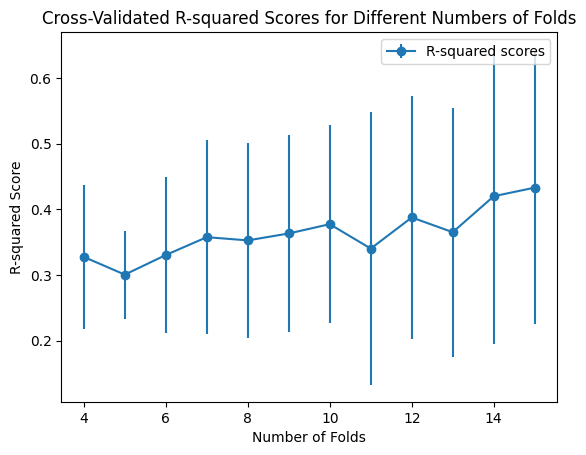

In [ ]:
# Lists to store results
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

# Iterate over different numbers of folds
for n_folds in n_folds_values:
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

In [ ]:
# Importing necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Coefficient of Determination (R^2):", r2)


Mean Squared Error: 1.1553445228305256e+20
Coefficient of Determination (R^2): 0.0055439923727048646


Mean Squared Error: 9.504504587980818e+19
Coefficient of Determination (R^2): 0.3033985948470841


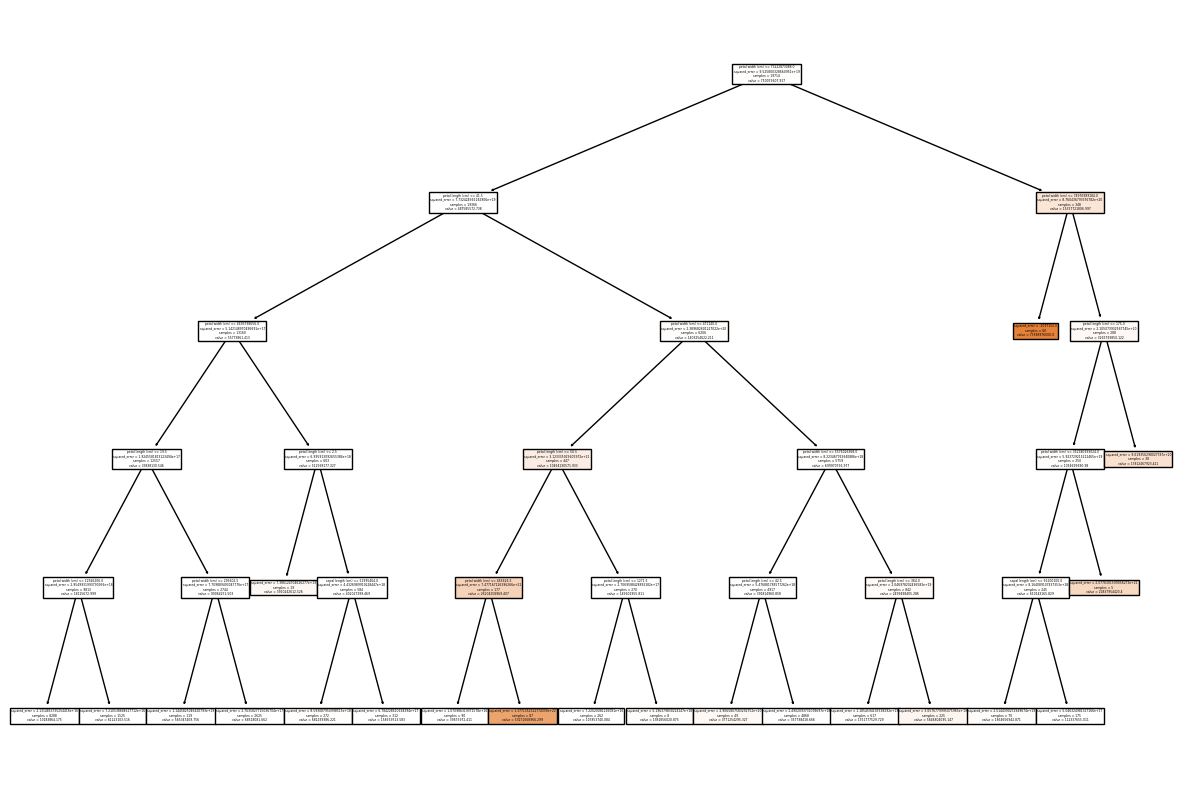

(28164, 6)


In [ ]:
# Importing necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Creating and training the decision tree regression model with hyperparameters to prevent overfitting
model = DecisionTreeRegressor(max_depth=5, min_samples_split=50, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Coefficient of Determination (R^2):", r2)

# Importing necessary libraries
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Plotting the decision tree
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

print(df3.shape)



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

class KNNRegression:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            nearest_neighbors = np.argsort(distances)[:self.k]
            prediction = np.mean(self.y_train[nearest_neighbors])
            predictions.append(prediction)
        return np.array(predictions)


# Instantiate KNN regression model
knn_reg = KNNRegression(k=5)

# Train the model
knn_reg.fit(X_train, y_train)

# Make predictions
y_pred = knn_reg.predict(X_test)

# Evaluate the model using mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U16')) -> None

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and training the KNN regression model
model = KNeighborsRegressor(n_neighbors=1000)  # You can adjust the number of neighbors (k) as needed
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Coefficient of Determination (R^2):", r2)


NameError: name 'df3' is not defined